# Advanced Research Module Usage

We start with some useful imports and constant definitions

In [1]:
import sys
sys.path.append('../../..')

import os
import shutil


import matplotlib
%matplotlib inline

from batchflow import Pipeline, B, C, V, D
from batchflow.opensets import MNIST
from batchflow.models.tf import VGG7, VGG16
from batchflow.research import Research, Option

In [2]:
BATCH_SIZE=64
ITERATIONS=1000
TEST_EXECUTE_FREQ=100

In [3]:
def clear_previous_results(res_name):
    if os.path.exists(res_name):
        shutil.rmtree(res_name)

## Reducing Extra Dataset Loads

### Running Research Sequentially

In previous tutorial we learned how to use Research to run experimetrs multiple times and with varying parameters.

Firstly we define a dataset to work with and a pipeline that reads this dataset

In [4]:
mnist = MNIST()
train_root = mnist.train.p.run_later(BATCH_SIZE, shuffle=True, n_epochs=None)

Then we define a grid of parameters whose nodes will be used to form separate experiments

In [5]:
grid = Option('layout', ['cna', 'can']) * Option('bias', [True, False])        

These parameters can be passed to model's configs using named expressions. 

In [6]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
}

After that we define a pipeline to run during our experiments. We initialise a pipeline variable `'loss'` to store loss on each iteration

In [7]:
train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
)

Each research is assigned with a name and writes its results to a folder with this name. The names must be unique, so if one attempts to run a research with a name that already exists, an error will be thrown. In the cell below we clear the results of previous research runs so as to allow multiple runs of a research. This is done solely for purposes of ths tutorial and should not be done in real work

In [8]:
res_name = 'simple_research'
clear_previous_results(res_name)

Finally we define a Research that runs the pipeline substituting its parameters using different nodes of the `grid`, and saves values of the `'loss'` named expressions to results.

In [9]:
research = (Research()
            .add_pipeline(train_root + train_template, variables='loss')
            .add_grid(grid))

research.run(n_reps=4, n_iters=10, name=res_name, bar=True)

Research simple_research is starting...


  0%|          | 0/160 [00:00<?, ?it/s]

Distributor has 16 jobs with 10 iterations. Totally: 160


100%|██████████| 160/160 [06:56<00:00,  2.61s/it]


16 experiments are run (4 grid nodes x 4 repetitions) each consisting of 10 iterations.

We can load results of the research and see that the table has 160 entries.

In [10]:
research.load_results().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 9
Data columns (total 6 columns):
bias          160 non-null object
iteration     160 non-null int64
layout        160 non-null object
loss          160 non-null float64
name          160 non-null object
repetition    160 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.8+ KB


### Branches: Reducing Data Loading and Preprocessing

Each experiment can be divided into 2 stages: root stage that is roughly same for all experiments (for example, data loading and preprocessing) and branch stage that varies. If data loading and preprocessing take significant time one can use the batches generated on a single root stage to feed to several branches that belong to different experiments. 

For example, if you want to test 4 different models, and yor workflow includes some complicated data preprocessing and augmentation that is done separatey for each model, you may want to do preprocessing and augmentation once and feed resulting batches of data to all these 4 models. 

![Title](img/Branch_Root_Figure_crop.png)

Figure above shows the difference. 

On the left, simple workflow is shown. Same steps of common preprocessing are performed 4 times, and the batches that are generated after different runs of common stages are also different due to shuffling and possible randomisation inside common steps.

On the right, common steps are performed once on root stage and the very same batches are passed to different branches. This has the advantage of reducing extra computations but it also reduces variability becauce all models get exactly same pieces of data.

To perform root-branch division, one should pass `root` and `branch` parameters to `add_pipeline()` and define number of branches per root via `branches` parameter of `run()`.

A root with corresponding branches is called a **job**. Note that different roots still produce different batches.

One constraint when using branches is that branch pipelines do not calculate dataset variables properly, so we have to redefine `model_config` and `train_template` and hard-code `'inputs/labels/classes'` parameter

In [11]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
}

train_template = (Pipeline()
            .init_variable('loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('loss', mode='w'))
)

res_name = 'no_extra_dataload_research'
clear_previous_results(res_name)
    
research = (Research()
            .add_pipeline(root=train_root, branch=train_template, variables='loss')
            .add_grid(grid))

research.run(n_reps=4, n_iters=10, branches=8, name=res_name, bar=True)


Research no_extra_dataload_research is starting...


  0%|          | 0/20 [00:00<?, ?it/s]

Distributor has 2 jobs with 10 iterations. Totally: 20


100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


Scince every root is now assigned to 8 branches, there are only 2 jobs.

We can see that the whole research duration reduced.
In this toy example we use only 10 iterations to make the effect of reduced dataset load more visible.

The numbers of results entries is the same. 

In [12]:
research.load_results().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160 entries, 0 to 9
Data columns (total 6 columns):
bias          160 non-null object
iteration     160 non-null int64
layout        160 non-null object
loss          160 non-null float64
name          160 non-null object
repetition    160 non-null int64
dtypes: float64(1), int64(2), object(3)
memory usage: 8.8+ KB


### Functions on Root

If each job has several branches, they are all executed in parallel threads. To run a function on root, one should add it with `on_root=True`.

Functions on root have required parameters `iteration` and `experiments` and optional keyword parameters. They are not allowed to return anything

In [13]:
res_name = 'on_root_research'
clear_previous_results(res_name)

def function_on_root(iteration, experiments):
    print('on root')
    
research = (Research()
            .add_function(function_on_root, execute="#0", on_root=True)
            .add_pipeline(root=train_root, branch=train_template, variables='loss')
            .add_grid(grid)
           )

research.run(n_reps=4, branches=8, n_iters=ITERATIONS, name=res_name, bar=True)

Research on_root_research is starting...


  0%|          | 0/2000 [00:00<?, ?it/s]

Distributor has 2 jobs with 1000 iterations. Totally: 2000
on root


 50%|█████     | 1000/2000 [03:38<03:38,  4.58it/s]

on root


100%|██████████| 2000/2000 [07:07<00:00,  4.68it/s]


## Improving Performance

Research can ran experiments in parallel if number of workers if defined in `workers` parameter. 
Each worker starts in a separate process and performs one or several jobs assigned to it. Moreover if several GPU's are accessible one can pass indices of GPUs to use via `gpu` parameter.

Following parameters are also useful to control research execution:
* `timeout` in `run` specifies time in minutes to kill non-responding job, default value is 5
* `trials` in `run` specifies number of attempts to restart a job, default=2
* `dump` in `add_pipeline`, `add_function` and `get_metrics` tells how often results are written to disk and cleared. By default results are dumped on the last iteration, but if they consume too much memory one may want to do it more often. The format is same as `execute`

In [14]:
model_config={
    'device': C('device'), # it's technical parameter for TFModel
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
    'common/conv/use_bias': C('bias'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
)

test_root = mnist.test.p.run_later(BATCH_SIZE, shuffle=True, n_epochs=1) #Note  n_epochs=1

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics')))

research = (Research()
            .add_pipeline(root=train_root, branch=train_template, variables='train_loss', name='train_ppl',
                          dump=TEST_EXECUTE_FREQ)
            .add_pipeline(root=test_root, branch=test_template, name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy',
                         returns='accuracy', 
                         execute=TEST_EXECUTE_FREQ,
                         dump=TEST_EXECUTE_FREQ,)
            .add_grid(grid))

res_name = 'faster_research'
clear_previous_results(res_name)

research.run(n_reps=4, n_iters=ITERATIONS, name=res_name, bar=True, 
             branches=2, workers=2, gpu=[5,6], 
             timeout=2, trials=1)

Research faster_research is starting...


  0%|          | 0/8000 [00:00<?, ?it/s]

Distributor has 8 jobs with 1000 iterations. Totally: 8000


100%|██████████| 8000/8000 [06:45<00:00, 19.74it/s]


In [15]:
results = research.load_results()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16160 entries, 0 to 9
Data columns (total 7 columns):
accuracy      160 non-null float64
bias          16160 non-null object
iteration     16160 non-null int64
layout        16160 non-null object
name          16160 non-null object
repetition    16160 non-null int64
train_loss    16000 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1010.0+ KB


## Cross-validation

One can easyly perform cross-validation with Research

Firstly we will define a dataset: we will use train subset of MNIST

In [16]:
mnist_train = MNIST().train

Next, we define our train and test pipelines. When performing cross-validation, Research will automatically split the dataset given and feed the folds to pipelines, so we will rather define pipeline templates that will wait for a dataset to work with. In contrast with previous tutorials we are adding `run` method to pipeline templates, not dataset pipelines.

In [17]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': D('num_classes'),
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

test_template = (Pipeline()
                 .init_variable('predictions')
                 .init_variable('metrics')
                 .import_model('conv', C('import_from'))
                 .to_array()
                 .predict_model('conv', 
                                images=B('images'), labels=B('labels'),
                                fetches='predictions', save_to=V('predictions'))
                 .gather_metrics('class', targets=B('labels'), predictions=V('predictions'), 
                                fmt='logits', axis=-1, save_to=V('metrics'))
                 .run_later(BATCH_SIZE, shuffle=True, n_epochs=1))

We are now defining our Research object. To use cross-validation we should pass `dataset` and `part` parameters to `add_pipeline` methods. We will use train subset of MNIST `mnist_train` created above, so we pass `dataset=mnist_train`. This subset was also split on train and test parts when created, so we pass `part='train'` when adding train pipeline and `part='test'` when adding test pipeline. We don't pass any dataset to `root` explicitely scince this is now Research that cares for data. 

Next, we call `run` with `n_splits` parameter that defines the number of cv folds. We can also pass `shuffle` to specify whether to shuffle the dataset before splitting. `shuffle` can be bool, int, `numpy.random.RandomState` or callable, its default value is *False* which means no shuffling.

In [18]:
grid = Option('layout', ['cna', 'can'])

research = (Research()
            .add_pipeline(train_template, dataset=mnist_train, part='train', variables='train_loss', name='train_ppl')
            .add_pipeline(test_template, dataset=mnist_train, part='test', name='test_ppl',
                         execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy', returns='accuracy', 
                         execute=TEST_EXECUTE_FREQ)
            .add_grid(grid))

res_name = 'cv_research'
clear_previous_results(res_name)
    
research.run(n_iters=ITERATIONS,
             n_splits=3, shuffle=True, 
             name=res_name, bar=True, workers=1, gpu=[5])

Research cv_research is starting...


  0%|          | 0/6000 [00:00<?, ?it/s]

Distributor has 6 jobs with 1000 iterations. Totally: 6000


100%|██████████| 6000/6000 [08:46<00:00, 11.40it/s]


We can now load results, specifying which folds to get if needed

In [19]:
results = research.load_results(folds=0)
results.sample(5)

,accuracy,cv_split,iteration,layout,name,repetition,train_loss
438,NaN,0,438,can,train_ppl,0,0.042195
719,NaN,0,719,can,train_ppl,0,0.160821
976,NaN,0,976,can,train_ppl,0,0.080790
863,NaN,0,863,cna,train_ppl,0,0.044702
978,NaN,0,978,cna,train_ppl,0,0.056546


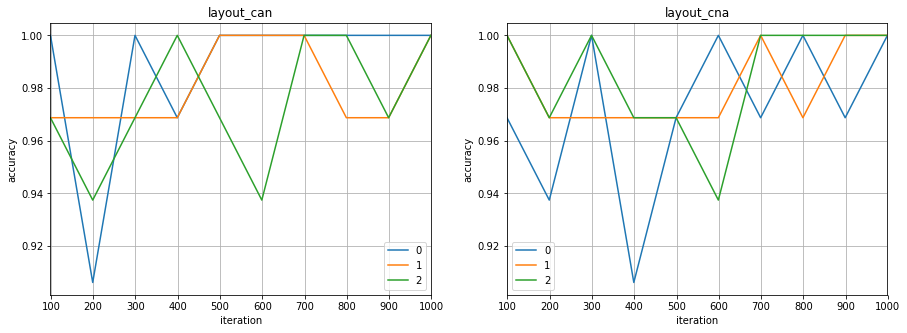

In [20]:
from matplotlib import pyplot as plt
test_results = research.load_results(names= 'test_ppl_metrics', use_alias=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i, (config, df) in enumerate(test_results.groupby('config')):
    x, y = i//2, i%2
    df.pivot(index='iteration', columns='cv_split', values='accuracy').plot(ax=ax[y])
    ax[y].set_title(config)
    ax[y].set_xlabel('iteration')
    ax[y].set_ylabel('accuracy')
    ax[y].grid(True)
    ax[y].legend()

### Cross Validation with Extra Performance Settings 

We can still use branch-root division to preprocess the data 

In [21]:
model_config={
    'inputs/images/shape': B('image_shape'),
    'inputs/labels/classes': 10,
    'inputs/labels/name': 'targets',
    'initial_block/inputs': 'images',
    'body/block/layout': C('layout'),
}

train_template = (Pipeline()
            .init_variable('train_loss')
            .init_model('dynamic', VGG7, 'conv', config=model_config)
            .to_array()
            .train_model('conv', 
                         images=B('images'), labels=B('labels'),
                         fetches='loss', save_to=V('train_loss', mode='w'))
            .run_later(BATCH_SIZE, shuffle=True, n_epochs=None))

augmentation_pipeline = Pipeline().salt(p=0.5).run_later(BATCH_SIZE, shuffle=True, n_epochs=None)

research = (Research()
            .add_pipeline(root=augmentation_pipeline, branch=train_template,
                          dataset=mnist_train, part='train', 
                          variables='train_loss', name='train_ppl')
            .add_pipeline(test_template, dataset=mnist_train, part='test', name='test_ppl',
                          execute=TEST_EXECUTE_FREQ, run=True, import_from='train_ppl')
            .get_metrics(pipeline='test_ppl', metrics_var='metrics', metrics_name='accuracy', returns='accuracy', 
                         execute=TEST_EXECUTE_FREQ)
            .add_grid(grid))

res_name = 'cv_branches_research'
clear_previous_results(res_name)

research.run(n_iters=ITERATIONS,
             n_splits=3, shuffle=True,
             workers=2, gpu=[5,6], 
             branches=2, 
             name=res_name, bar=True)

research.load_results().info()


Research cv_branches_research is starting...


  0%|          | 0/3000 [00:00<?, ?it/s]

Distributor has 3 jobs with 1000 iterations. Totally: 3000


100%|██████████| 3000/3000 [04:55<00:00, 10.14it/s]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6060 entries, 0 to 9
Data columns (total 7 columns):
accuracy      60 non-null float64
cv_split      6060 non-null int64
iteration     6060 non-null int64
layout        6060 non-null object
name          6060 non-null object
repetition    6060 non-null int64
train_loss    6000 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 378.8+ KB
